This notebook's sole focus is to find the insights from the metadata file given by SUANfarma

Lets import all the packages and user-defined functions (from udf_eda.py)

In [2]:
from tqdm import tqdm
import numpy as np
np.set_printoptions(suppress=True) #prevent numpy exponential 

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '../src')

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

# importing user-defined functions from udf_eda.py
import udf_eda as udf

In [3]:
df = pd.read_excel('../../../data/input/11_Dataset/produzione_CStOA_2021_ed12.xlsx', sheet_name="dati-produzione", header=1)
# Remove constants
df.drop(columns = df.loc[:, df.nunique() == 1].columns.values, inplace=True)
# Remove NaN columns
df.dropna(axis=1,how='all', inplace= True)
# Remove rows where id is null
df.dropna(subset=['O.D.P.'], how='all', inplace=True)
df.insert(0, 'id', df['O.D.P.'].astype(int).astype(str).str[-4:])
df.insert(1, 'result', df.Resa)
df.drop(columns=['Resa'], inplace=True)
df.drop(columns= ["N°", "O.D.P."], inplace= True)
print(df.shape)
df = udf.drop_duplicate_columns(df)

(206, 117)


100%|██████████| 117/117 [00:00<00:00, 789.71it/s]


In [4]:
cols = df.columns
cols = [w.replace('  ', ' ') for w in cols]
cols = [w.replace('  ', ' ') for w in cols]
cols = [w.replace('  ', ' ') for w in cols]
cols = [w.replace('  ', ' ') for w in cols]
cols = [w.replace('  ', ' ') for w in cols]
cols = [w.replace('  ', ' ') for w in cols]
cols = [w.replace('Pc n°', 'PCN') for w in cols]
cols = [w.replace(' (', '(') for w in cols]
cols = [w.replace(') ', ')') for w in cols]
cols = [w.replace('( ', '(') for w in cols]
cols = [w.replace(' )', ')') for w in cols]
cols = [w.replace(' ', '_') for w in cols]
cols = [w.replace('.', '') for w in cols]
cols = [w.replace('ª', '') for w in cols]
cols = [w.replace('°', '') for w in cols]
cols = [w.replace('__', '_') for w in cols]
df.columns = cols

In [5]:
df_desc = udf.describe(df).T
df_desc.loc[df_desc['perc_null'] > 10].shape

(33, 14)

# of columns before dropping correlated variables:  116
# of columns to drop 27
Dropped columns after correlation analysis: ['volume_acetone(mc)-74-', '2_Crist_PCN_10_Tempfine_risc(C)', '2_Crist_TOA_aggiunta(lt)-84-', 'volume_acetone(mc)-90-', '3_Crist_PCN_13_Tempfine_risc(C)', '3_Crist_TOA_aggiunta(lt)-100-', 'volume_acetone(mc)-106-', '4_Crist_PCN_16_Tempfine_risc(C)', 'volume_acetone(mc)', '5_Crist_TOA_aggiunta(lt)', 'Cris_Totale_TOA(lt)', 'Volume_acetone_di_lavaggio_1_ciclo(lt)', 'Volume_acetone_di_lavaggio_2_ciclo(lt)', 'Volume_acetone_di_lavaggio_6_ciclo(lt)', 'Conf_Parte_A(Kg)', 'Conf_Parte_B_N_fusti', 'Conf_Parte_B(Kg)', 'Conf_Parte_C_N_fusti', 'Conf_Parte_C(Kg)', 'Conf_Totale_Conf(Kg)', '107_/108_lavaggio_nanofiltraz_EDTA(Kg)', 'Week', 'volume_del_BHV_trattato(mc)', 'PCN36_KgA_del_BHV_trattato_30_', 'PCN_37_Resa_di_processo(%)', 'LAB_CQ_AM_titolo(mg/lt)', 'CFF_Volume_DW_dil30_%(mc)']


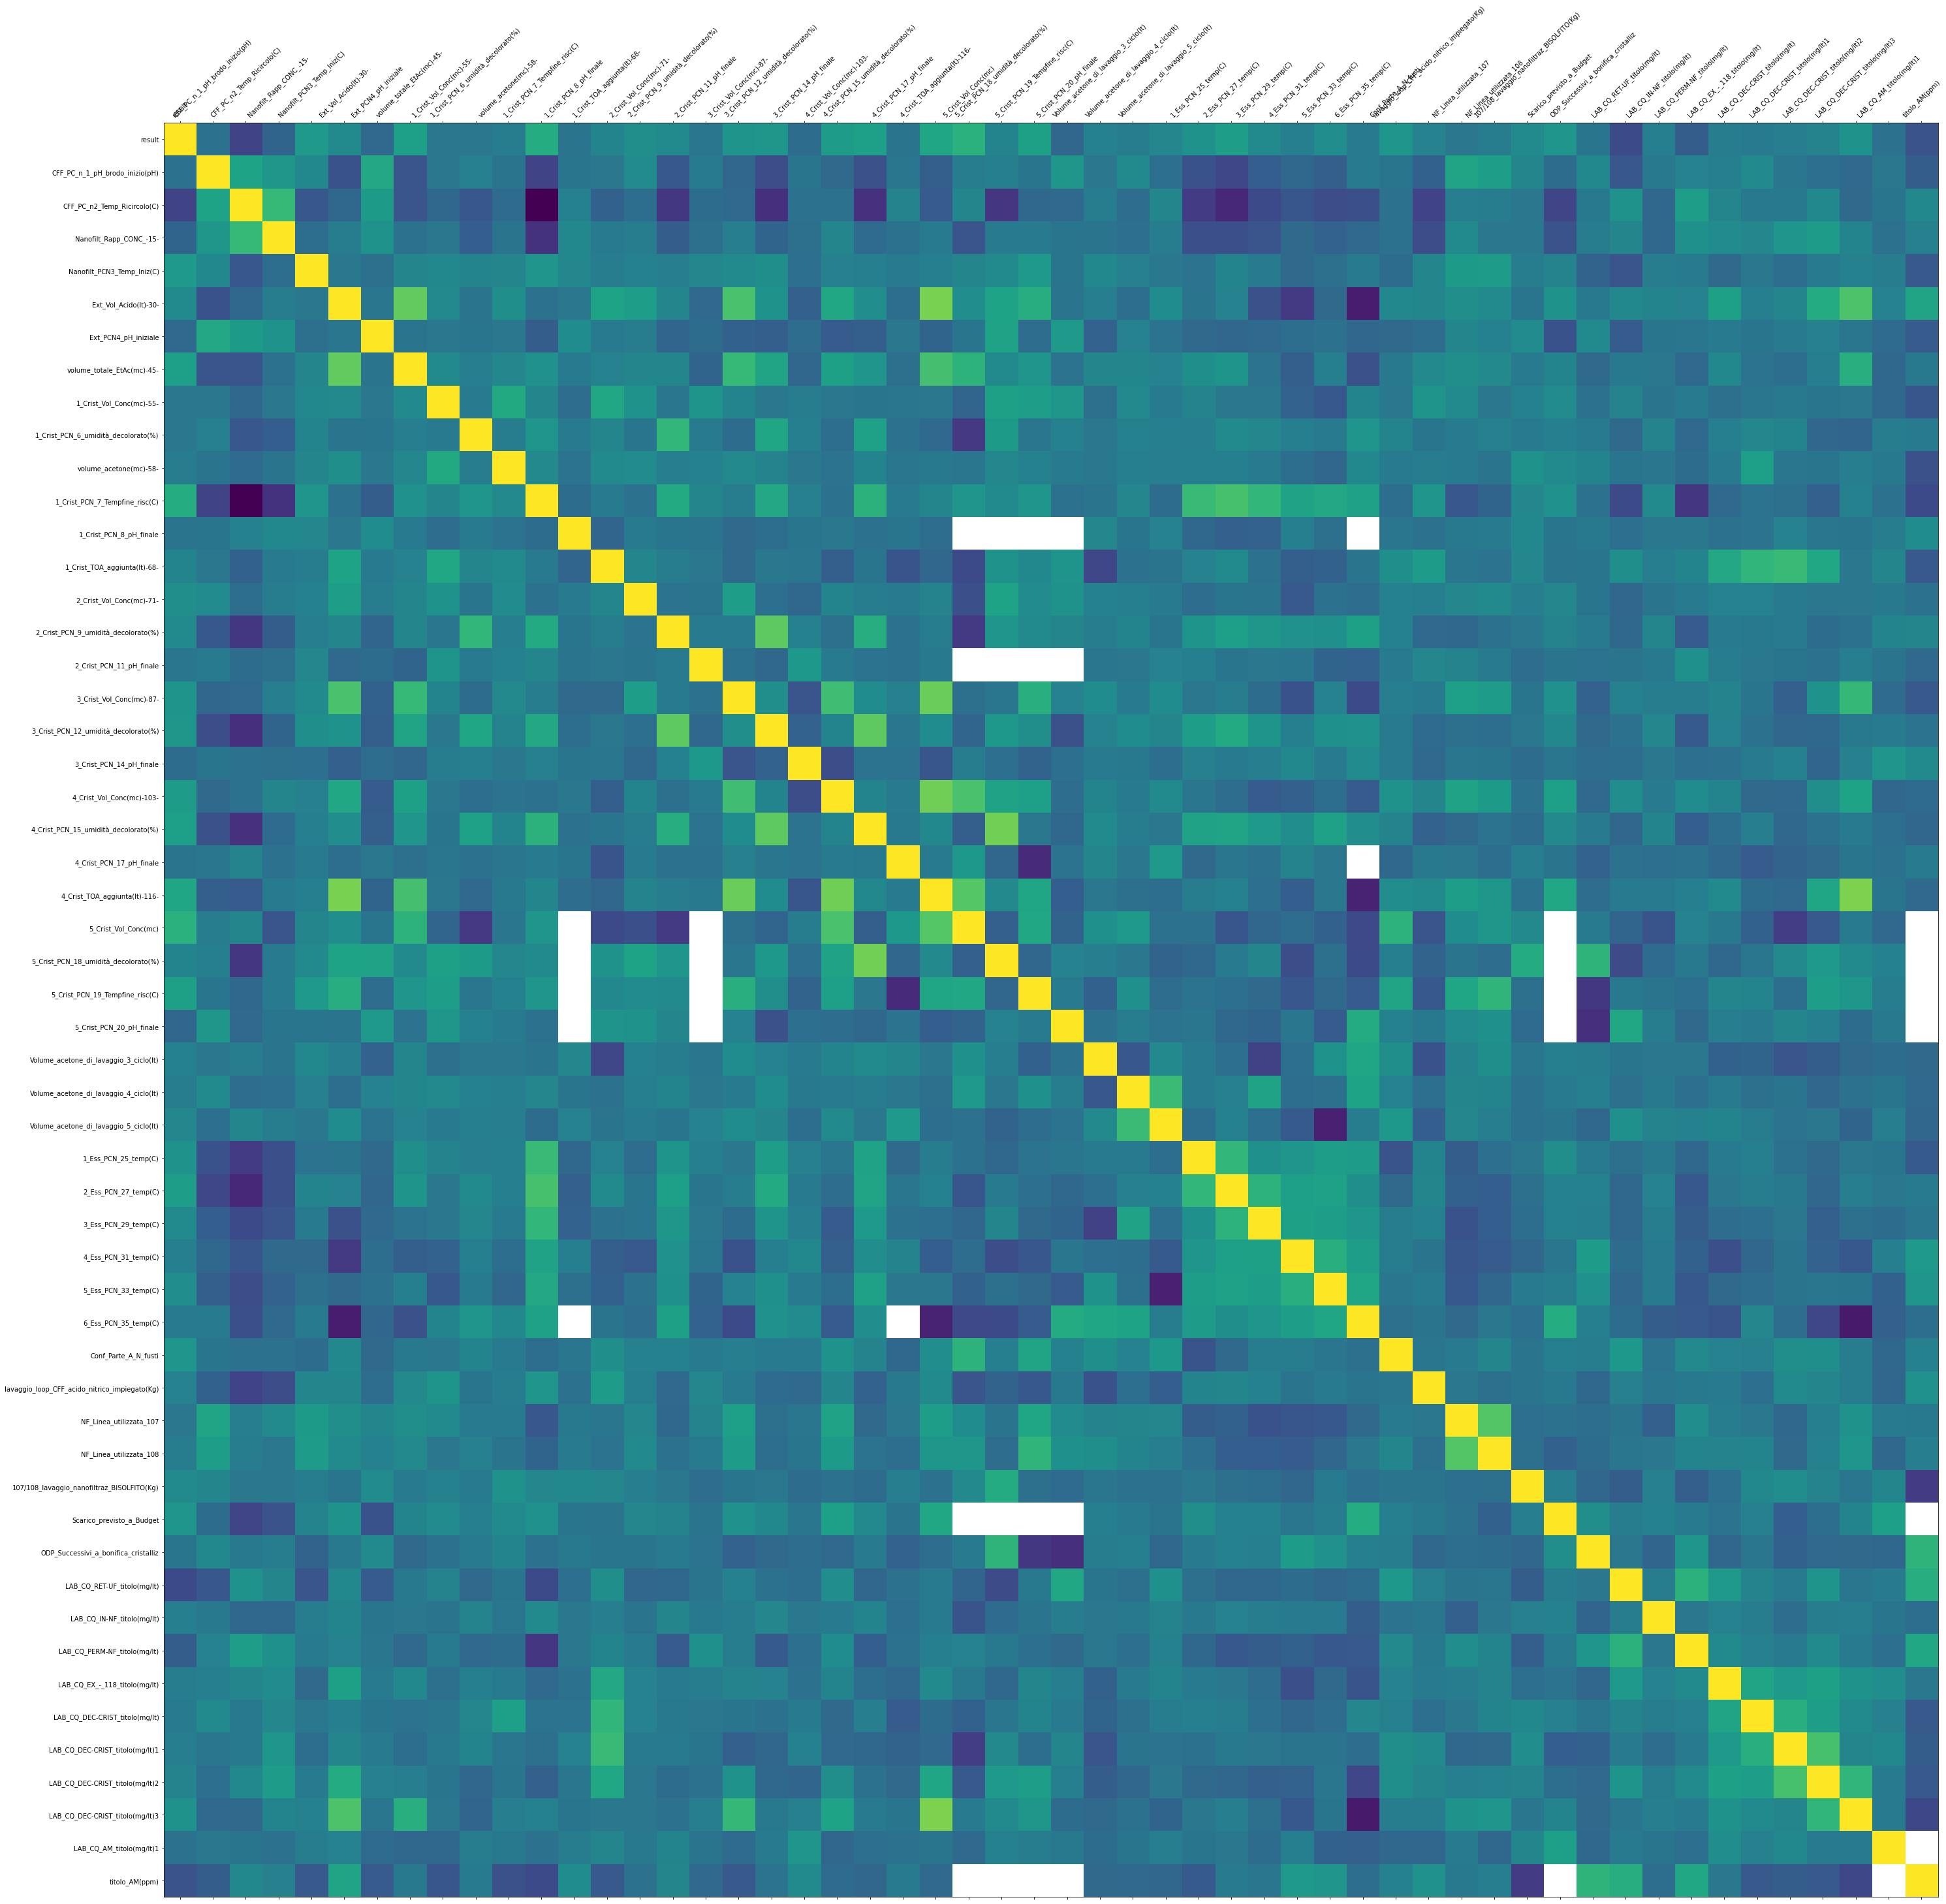

In [6]:
# 0.9 - 11
# 0.8 - 20
# 0.7 - 27
df = udf.eliminate_corr(df,thresh = 0.7)
udf.plot_corr(df, 50)

In [7]:
print("How many NaN values exist in the data: ", df.isna().sum().sum())

How many NaN values exist in the data:  2205


In [8]:
mostly_nan_vars = udf.describe(df).T[udf.describe(df).T['perc_null'] > 12].index.tolist()
df.drop(columns=mostly_nan_vars, inplace= True)
df.fillna(df.mean(), inplace=True)

In [9]:
udf.describe(df).T[udf.describe(df).T['perc_null'] > 0]

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,dtype,size,perc_null
4_Ess_Inizio(hh:mm),202,187,03:09:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,206,1.94175
4_Ess_Fine(hh:mm),202,191,04:50:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,206,1.94175
Data_fine_ultimo_conf_,205,NaN,NaN,NaN,2021-05-22 09:14:55.609756160,2021-01-01 00:00:00,2021-03-09 00:00:00,2021-05-30 00:00:00,2021-07-31 00:00:00,2021-10-06 00:00:00,NaN,datetime64[ns],206,0.48544
Ora_fine_ultimo_conf_,205,155,16:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,206,0.48544


In [10]:
df.dtypes

id                                         object
result                                    float64
Data_inizio_CFF                    datetime64[ns]
Ora_inizio_CFF                             object
CFF_PC_n_1_pH_brodo_inizio(pH)            float64
                                        ...      
LAB_CQ_PERM-NF_titolo(mg/lt)              float64
LAB_CQ_EX_-_118_titolo(mg/lt)             float64
LAB_CQ_DEC-CRIST_titolo(mg/lt)            float64
LAB_CQ_DEC-CRIST_titolo(mg/lt)1           float64
LAB_CQ_DEC-CRIST_titolo(mg/lt)2           float64
Length: 69, dtype: object

In [11]:
categorical = df.columns[(df.dtypes.values != np.dtype('float64'))]
x_train = df[df.columns[~df.columns.isin(categorical)]]
x_train = x_train[x_train.columns[~x_train.columns.isin(['result'])]]
y_train = df.result

In [12]:
reg_EN = ElasticNet(fit_intercept=True, random_state=1234)
pipe_reg_EN = Pipeline(
    [
        # ("std_scaler", StandardScaler()),
        ("regressor", reg_EN),
    ]
)
pipe_reg_EN.fit(x_train, y_train)

print('Coefficients: \n',pipe_reg_EN.named_steps["regressor"].coef_.flatten())
print('Intercept: ',pipe_reg_EN.named_steps["regressor"].intercept_)
print('R- Squared:', pipe_reg_EN.score(x_train, y_train))


Coefficients: 
 [-0.         -0.         -0.          0.          0.         -0.
  0.          0.         -0.          0.          0.         -0.
  0.          0.          0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.00004279  0.
  0.00000067  0.          0.          0.          0.          0.
  0.         -0.         -0.          0.         -0.00006379  0.00000107
 -0.          0.00000088  0.00000007  0.0000002   0.00000026]
Intercept:  0.7090260913703087
R- Squared: 0.1638559700540163


In [13]:
reg_Lasso = Lasso(alpha=0.1, fit_intercept = True)
pipe_reg_Lasso = Pipeline(
    [
        # ("std_scaler", StandardScaler()),
        ("regressor", reg_Lasso),
    ]
)
pipe_reg_Lasso.fit(x_train, y_train)

print('Coefficients: \n',pipe_reg_Lasso.named_steps["regressor"].coef_.flatten())
print('Intercept: ',pipe_reg_Lasso.named_steps["regressor"].intercept_)
print('R- Squared:', pipe_reg_Lasso.score(x_train, y_train))

Coefficients: 
 [-0.         -0.         -0.          0.         -0.00000833 -0.
  0.         -0.         -0.          0.          0.         -0.
  0.00007439  0.          0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.00006536  0.0000527
  0.00000391  0.          0.          0.          0.          0.
  0.00000697 -0.         -0.          0.0000167  -0.00008147  0.0000011
 -0.00002023  0.00000119 -0.00000011 -0.00000003  0.00000026]
Intercept:  0.6177017352308349
R- Squared: 0.22102778725281313


In [14]:
reg_Ridge = Ridge(alpha=0.5, fit_intercept= True)
pipe_reg_Ridge = Pipeline(
    [
        ("std_scaler", StandardScaler()),
        ("regressor", reg_Ridge),
    ]
)
pipe_reg_Ridge.fit(x_train, y_train)

print('Coefficients: \n',pipe_reg_Ridge.named_steps["regressor"].coef_.flatten())
print('Intercept: ',pipe_reg_Ridge.named_steps["regressor"].intercept_)
print('R- Squared:', pipe_reg_Ridge.score(x_train, y_train))


Coefficients: 
 [ 0.00398241  0.00062795 -0.00120181  0.00519305 -0.00856303 -0.00299248
  0.00913918 -0.00239387 -0.00606719 -0.00030933  0.00664485  0.00079234
  0.00572884  0.00475515  0.00007033 -0.00068779  0.00071114  0.00123698
 -0.0005867   0.00599183  0.00302576  0.00013908  0.00413366 -0.00082526
 -0.00157504  0.00350949  0.00494833 -0.00237783 -0.000369    0.01203367
 -0.00116295 -0.00244434 -0.00127319  0.00193736 -0.0119219   0.00122036
 -0.00103828  0.0025782  -0.00238625 -0.00048824  0.00349842]
Intercept:  0.7336671282795386
R- Squared: 0.4333903268119884


In [15]:
reg_SDG = SGDRegressor(max_iter=1000, tol=1e-3,fit_intercept= True, random_state= 1234)
pipe_reg_SDG = Pipeline(
    [
        ("std_scaler", StandardScaler()),
        ("regressor", reg_SDG),
    ]
)
pipe_reg_SDG.fit(x_train, y_train)

print('Coefficients: \n',pipe_reg_SDG.named_steps["regressor"].coef_.flatten())
print('Intercept: ',pipe_reg_SDG.named_steps["regressor"].intercept_)
print('R- Squared:', pipe_reg_SDG.score(x_train, y_train))

Coefficients: 
 [ 0.00342172 -0.00622241 -0.00069528  0.00524888 -0.00327123 -0.0016796
  0.00543339 -0.00288514 -0.00380044  0.00166633  0.00228285 -0.00014841
  0.00674367  0.00169598 -0.0029645  -0.00062132  0.00283953  0.0002128
 -0.00088103  0.00769209  0.00280292  0.00049342  0.00234033  0.00222093
 -0.0003626   0.0037626   0.00247699  0.00177779  0.00146813  0.00887544
 -0.00232253 -0.00426638 -0.00020292  0.00235628 -0.01231806  0.00084244
 -0.00102166  0.00365698 -0.00453018  0.00236207  0.00174033]
Intercept:  [0.72601637]
R- Squared: 0.3667831839931437


In [16]:
reg_LR = LinearRegression()
pipe_reg_LR = Pipeline(
    [
        ("std_scaler", StandardScaler()),
        ("regressor", reg_LR),
    ]
)
pipe_reg_LR.fit(x_train, y_train)

print('Coefficients: \n',pipe_reg_LR.named_steps["regressor"].coef_.flatten())
print('Intercept: ',pipe_reg_LR.named_steps["regressor"].intercept_)
print('R- Squared:', pipe_reg_LR.score(x_train, y_train))

Coefficients: 
 [ 0.00399043  0.00067415 -0.00121469  0.00519043 -0.00871191 -0.00301147
  0.00922172 -0.00241523 -0.00609867 -0.00028442  0.00667243  0.00080923
  0.0057912   0.00478606  0.00008921 -0.00069483  0.00071699  0.00124416
 -0.00058203  0.00599721  0.00303252  0.00014588  0.00416159 -0.0008593
 -0.00159469  0.00351386  0.00497997 -0.00243473 -0.00039922  0.01208757
 -0.0011772  -0.00245716 -0.00127584  0.00191552 -0.01197325  0.00123351
 -0.0010229   0.00258688 -0.00242725 -0.00050311  0.00352854]
Intercept:  0.7336671282795386
R- Squared: 0.4333975045465547


In [17]:

coeff = pd.DataFrame(list(zip(
            x_train.columns,
            pipe_reg_LR.named_steps["regressor"].coef_.flatten(), 
            pipe_reg_Lasso.named_steps["regressor"].coef_.flatten(), 
            pipe_reg_Ridge.named_steps["regressor"].coef_.flatten(), 
            pipe_reg_EN.named_steps["regressor"].coef_.flatten(), 
            pipe_reg_SDG.named_steps["regressor"].coef_.flatten()
            )), columns = ['Feature', 'LR', 'Lasso', 'Ridge', 'EN', 'SDG'])
coeff

,Feature,LR,Lasso,Ridge,EN,SDG
0,CFF_PC_n_1_pH_brodo_inizio(pH),0.00399,-0.00000,0.00398,-0.00000,0.00342
1,CFF_PC_n2_Temp_Ricircolo(C),0.00067,-0.00000,0.00063,-0.00000,-0.00622
2,Nanofilt_Rapp_CONC_-15-,-0.00121,-0.00000,-0.00120,-0.00000,-0.00070
3,Nanofilt_PCN3_Temp_Iniz(C),0.00519,0.00000,0.00519,0.00000,0.00525
4,Ext_Vol_Acido(lt)-30-,-0.00871,-0.00001,-0.00856,0.00000,-0.00327
5,Ext_PCN4_pH_iniziale,-0.00301,-0.00000,-0.00299,-0.00000,-0.00168
6,volume_totale_EtAc(mc)-45-,0.00922,0.00000,0.00914,0.00000,0.00543
7,1_Crist_Vol_Conc(mc)-55-,-0.00242,-0.00000,-0.00239,0.00000,-0.00289
8,1_Crist_PCN_6_umidità_decolorato(%),-0.00610,-0.00000,-0.00607,-0.00000,-0.00380
9,volume_acetone(mc)-58-,-0.00028,0.00000,-0.00031,0.00000,0.00167


In [21]:
coeff.sort_values(by = 'LR')

,Feature,LR,Lasso,Ridge,EN,SDG
34,LAB_CQ_RET-UF_titolo(mg/lt),-0.01197,-0.00008,-0.01192,-0.00006,-0.01232
4,Ext_Vol_Acido(lt)-30-,-0.00871,-0.00001,-0.00856,0.00000,-0.00327
8,1_Crist_PCN_6_umidità_decolorato(%),-0.00610,-0.00000,-0.00607,-0.00000,-0.00380
5,Ext_PCN4_pH_iniziale,-0.00301,-0.00000,-0.00299,-0.00000,-0.00168
31,NF_Linea_utilizzata_107,-0.00246,-0.00000,-0.00244,-0.00000,-0.00427
27,3_Ess_PCN_29_temp(C),-0.00243,0.00000,-0.00238,0.00000,0.00178
38,LAB_CQ_DEC-CRIST_titolo(mg/lt),-0.00243,-0.00000,-0.00239,0.00000,-0.00453
7,1_Crist_Vol_Conc(mc)-55-,-0.00242,-0.00000,-0.00239,0.00000,-0.00289
24,Volume_acetone_di_lavaggio_4_ciclo(lt),-0.00159,0.00000,-0.00158,0.00000,-0.00036
32,NF_Linea_utilizzata_108,-0.00128,-0.00000,-0.00127,-0.00000,-0.00020


In [25]:
x_train[['LAB_CQ_RET-UF_titolo(mg/lt)', 'Conf_Parte_A_N_fusti']].describe()

,LAB_CQ_RET-UF_titolo(mg/lt),Conf_Parte_A_N_fusti
count,206.00000,206.00000
mean,447.62755,12.75243
std,157.31711,0.72709
min,0.00000,6.00000
25%,348.00000,13.00000
50%,441.00000,13.00000
75%,517.50000,13.00000
max,1256.00000,15.00000


In [85]:
coeff.to_csv('../../../data/output/metadata_model_coeff_V1.csv', index=False)